# Capacitated Facility Location Problem

In [1]:
test_name = "16 BCFLP"
sample_fraq = 1
randomSeed = 11


In [2]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance

import missingno as msno

# Plotting modules
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.basemap import Basemap

# Linear programming modules
import pulp

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# == Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# == Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# == Clustering
from sklearn.cluster import KMeans
from sklearn_som.som import SOM
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# == Neural Networks
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# == Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


## Load the data

In [3]:
# import the data and parameters and check the data

data_path = "data/"
start_time = time.time()
# ====Parameters==== #
parameters = pd.read_csv(os.path.join(data_path, "parametros.csv"))
# 1. food_per_person_per_day in tons per day
food_per_person_per_day = float(
    parameters.loc[parameters["parametro"] == "comida_por_persona_en_toneladas"].values[
        0
    ][1]
)
# 2. transport_cost_per_ton_per_km in COP per ton per km
transport_cost_per_ton_per_km = float(
    parameters.loc[
        parameters["parametro"] == "costo_de_transporte_por_tonelada_por_kilomentro"
    ].values[0][1]
)

print(
    f"parameters: \n    food_per_person_per_day: {food_per_person_per_day} \n    transport_cost_per_ton_per_km: {transport_cost_per_ton_per_km}\n"
)
# ====Parameters==== #

# ====importData==== #
# 1. population, from data/municipios_procesado.csv
population = pd.read_csv(
    os.path.join(data_path, "municipios_procesado.csv"), index_col=3
)
# 2. distance, from data/distance_matrix_final.csv
distance = pd.read_csv(
    os.path.join(data_path, "distance_matrix_final.csv"), index_col=0
)
# 3. warehouses, from data/almacenes.csv
warehouses = pd.read_csv(os.path.join(data_path, "almacenes.csv"))
# ====importData==== #

# ====DataProcessing===== #
# fill the nan values in population with the minimum '2024' from the departamento of Chocó for the columns 22:
population.loc[population.isna().any(axis=1), population.columns[18:]] = (
    population[
        population["2024"]
        == population.loc[population["departamento"] == "Chocó"]["2024"].min()
    ]
    .iloc[0, 18:]
    .values
)
# drop the municipalities with nan values in the first column of the distance matrix
distance = distance.dropna(subset=[distance.columns[0]], axis=0)
distance = distance.dropna(subset=[distance.index[0]], axis=1)
# turn the columns of distance into integers
distance.columns = distance.columns.astype(int)
# Take a sample of the data
distance = distance.sample(frac=sample_fraq, random_state=randomSeed)
distance = distance.loc[
    :, distance.index
]  # make the distance matrix symmetric # type: ignore
# if there is a 0 value that is not in the diagonal, replace it with the mean of the column
for i in distance.index:
    for j in distance.columns:
        if distance.loc[i, j] == 0 and i != j:
            distance.loc[i, j] = np.nan
# Drop the nan values
distance = distance.dropna()
# make the distance matrix symmetric
distance = distance.loc[:, distance.index]
# turn distance to km
distance = distance / 1000
# select only the rows in population dpmp that the index is in distance
population = population.loc[distance.index]
# Check if every value of distance is larger than the linear distance for every pair of municipalities in population lat and lon are in the population dataframe
for i in distance.index:
    for j in distance.columns:
        if i != j:
            # get the linear distance
            linear_distance = geopy.distance.distance(
                (population.loc[i, "lat"], population.loc[i, "lon"]),
                (population.loc[j, "lat"], population.loc[j, "lon"]),
            ).km
            # check if the linear distance is larger than the distance in the distance matrix
            if linear_distance > distance.loc[i, j]:
                distance.loc[i, j] = linear_distance
# Check if there are any nan values in distance
if distance.isna().any().any():
    print("There are nan values in the distance matrix")
print(
    f"data information: \n    population: {population.shape} \n    distance: {distance.shape} \n    warehouses: \n {warehouses} \n"
)
# ====DataProcessing===== #

# ====DataInformation==== #
# Memory usage of the data
print(f"population memory usage: {population.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"distance memory usage: {distance.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"warehouses memory usage: {warehouses.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
# ====DataInformation==== #

# ====DataChecking==== #
# Test to the data if needed
# ====DataChecking==== #
print(f"Elapsed time: {time.time() - start_time:.2f} s")


parameters: 
    food_per_person_per_day: 0.00087617 
    transport_cost_per_ton_per_km: 3364.0

data information: 
    population: (1089, 71) 
    distance: (1089, 1089) 
    warehouses: 
    Type  capacity_ton        cost
0     1          1074  3111202.75
1     2          2418  4804980.75 

population memory usage: 0.63 MB
distance memory usage: 9.09 MB
warehouses memory usage: 0.00 MB
Elapsed time: 322.34 s


## 1. Demand Forecast

we are using the data from the population dataset that has the colombian census information since 1985 to 2035, the current year is 2024 and the last census was performed in 2018, the data was taken on december 2023 from the DANE web page.

First we need to check the current forecast, then use 4 ML algorithms and Deep Learning to create a new model. The Machine Learning algorithms are:
- Multiple Linear Regression.
- Regression Tree.
- Support Vector Machine.
- Random Forest Regression.

Then, we need the Mean Absolute Error (MAE) to compare the models. The best model will be used to forecast the demand for the next 30 years.

missing values: 0.02
amount of columns with missing values: 84
columns with missing values on row 2023: [94663]


lowBound-UpBound
1985-2023    1005
1993-2023      11
1996-2023      10
2000-2023       9
1997-2023       8
1999-2023       8
1990-2023       7
1998-2023       7
1995-2023       7
1991-2023       4
1986-2023       3
2001-2023       3
2008-2023       3
2007-2023       1
1994-2023       1
1991-2019       1
2002-2023       1
Name: count, dtype: int64

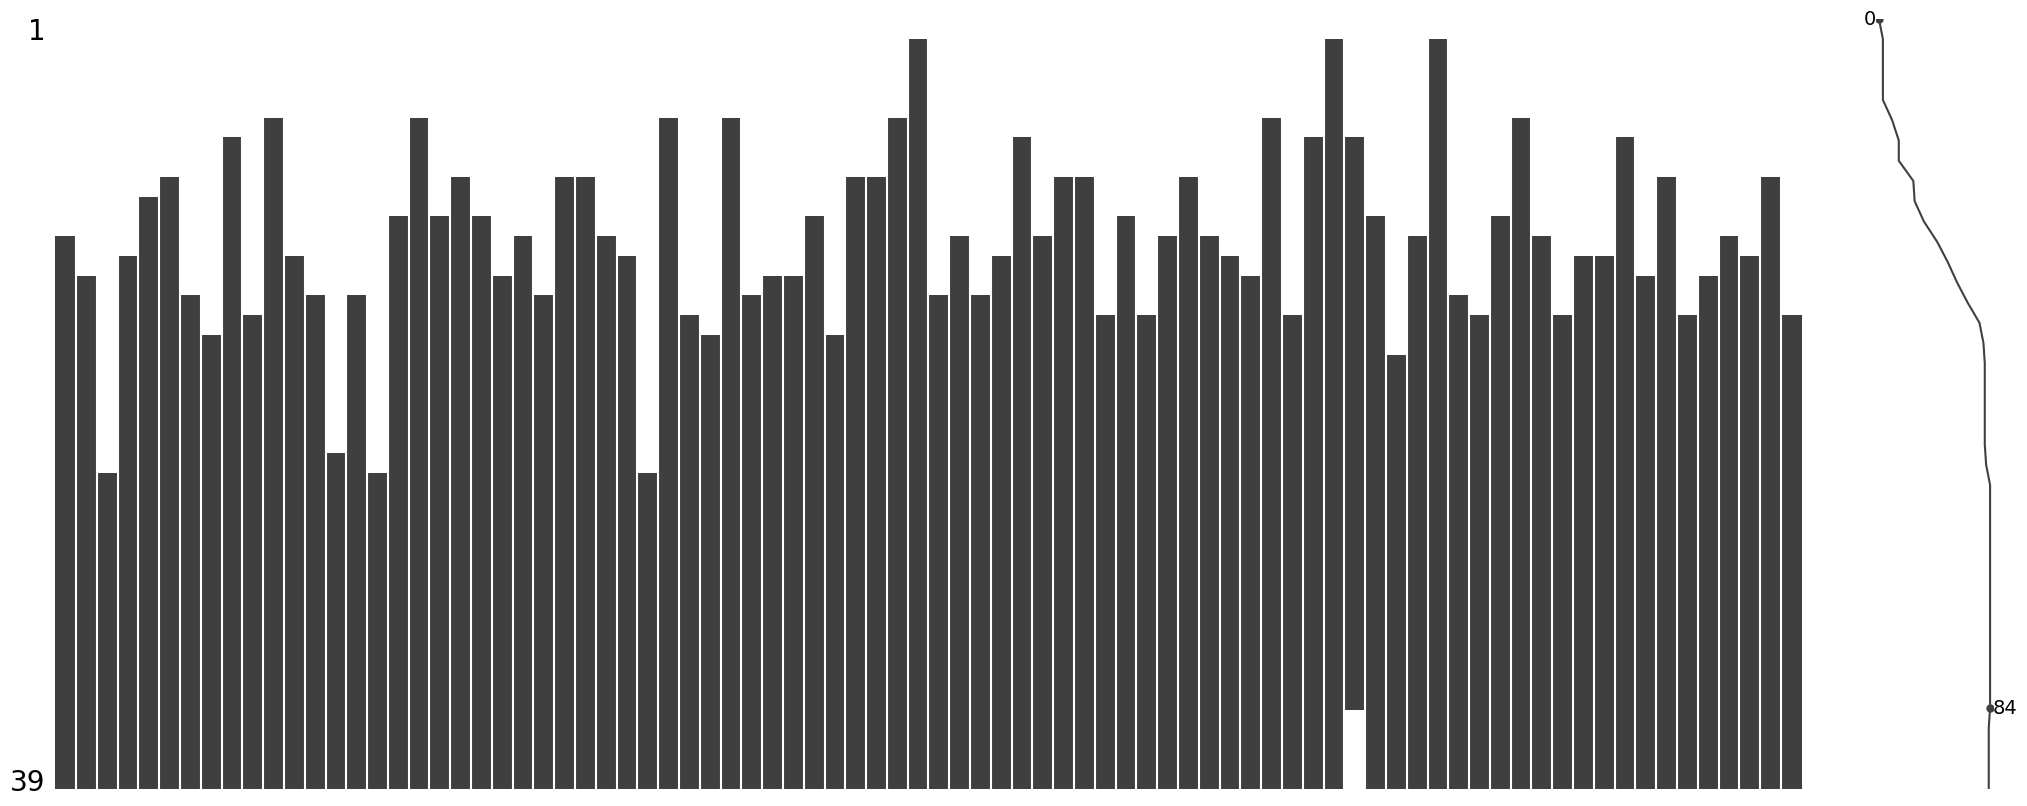

In [19]:
# ## 1. Demand Forecast

# 1. Demand Forecast

data = population.copy().iloc[:, 20:59]
data = data.transpose()

# place a nan in the 0 values
data = data.replace(0, np.nan)
# percentage of missing values in the data
missing_values = data.isna().sum().sum() / (data.shape[0] * data.shape[1])
print(f"missing values: {missing_values:.2f}")
# Columns with missing values
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(f"amount of columns with missing values: {len(columns_with_missing_values)}")
missing_columns = data[columns_with_missing_values]
# Plot the missing values
msno.matrix(missing_columns)

# Get the column name of the columns with missing values on row "2023"
columns_with_missing_values = data.columns[data.loc["2023"].isna()].tolist()
print(f"columns with missing values on row 2023: {columns_with_missing_values}")
# line plot of the column with missing values
fig = go.Figure()
for i in columns_with_missing_values:
    fig.add_trace(go.Scatter(x=data.index, y=data[i], mode="lines", name=i))
fig.update_layout(title="Demand Forecast", xaxis_title="Year", yaxis_title="Population")
fig.show()

# Make a new pandas Series with the Range for each column withou missing values
range = pd.DataFrame(index=data.columns, columns=["lowBound", "upBound"])
for i in data.columns:
    lowBound_index = data[i].first_valid_index()
    upBound_index = data[i].last_valid_index()
    range.loc[i, "lowBound"] = lowBound_index
    range.loc[i, "upBound"] = upBound_index

range["lowBound-UpBound"] = range["lowBound"] + "-" + range["upBound"]
# Frecuency table of the range
range["lowBound-UpBound"].value_counts()
